# Mutation Risk

In this notebook, we show the mutation risk as predicted by the MHN posterior samples.
This notebook produces figs. 3C, 3D, 4C, 4D and supplementary figs. S1 and S2.

In [ ]:
from utils import analysis, plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

burn_in = 0.2

/home/lhu/mhn_env/lib/python3.10/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [ ]:
data_name = "G13_COAD_12"  # change to "G13_LUAD_12" for LUAD dataset

samples = np.load(
    "../results/mcmc/G13_LUAD_12_symsparse_MALA_0_0015185546875000002.npy"
    if data_name == "G13_LUAD_12"
    else "../results/mcmc/G13_COAD_12_symsparse_MALA_0_001.npy")[:, ::100]
samples = samples[int(len(samples)*burn_in):]
samples = samples.reshape((-1, samples.shape[-1]))

data = pd.read_csv(f"../data/{data_name}.csv", index_col=0)

In [15]:
risks = analysis.event_risks(
    samples,
    data=data,
    n_samples="all",
    trajectory_num=1000,
)

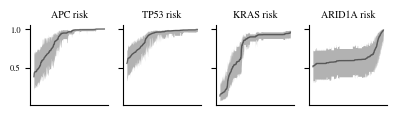

In [ ]:
events = [0, 1, 2, 3] if data_name == "G13_LUAD_12" else [0, 1, 2, 6]

fig, ax = plt.subplots(1, len(events), figsize=(4.6, 1.4), sharey=True)
fig.subplots_adjust(bottom=0.31)

for i, event in enumerate(events):

    a = ax[i]

    data_filtered = data.reset_index(drop=True)[
        data.reset_index(drop=True).iloc[:, event] == 0]
    sorting = None

    risk = risks[data_filtered.index, :, event]
    sorting = np.argsort(np.median(risk, axis=1))
    a.plot(np.median(risk, axis=1)[sorting], lw=1, alpha=0.5, color="black")
    a.fill_between(
        np.arange(risk.shape[0]),
        np.percentile(risk, 5, axis=1)[sorting],
        np.percentile(risk, 95, axis=1)[sorting],
        alpha=0.3, color="black", lw=0)
    a.set_title(f"{data.columns[event]} risk")
    for side in ["top", "right"]:
        a.spines[side].set_visible(False)
    a.set_xticks([])

## Association of Mutation Risk with Patient Survival

In [41]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival

In [42]:
survival = pd.read_table("../data/msk_chord_2024_clinical_data.tsv",
                         index_col="Sample ID",
                         usecols=[
                             "Overall Survival Status",
                             "Overall Survival (Months)",
                             "Sample ID"])
survival.index = survival.index.map(lambda x: "GENIE-MSK-" + x)
survival = survival[survival.index.isin(data.index)]
survival["Overall Survival Status"] = survival["Overall Survival Status"].apply(
    lambda x: bool(x[0]))

filter_immuno = True
if data_name == "G13_LUAD_12":
    filter_kras = True
else:
    filter_kras = False

In [ ]:
if filter_immuno:
    treatment = pd.read_table("../data/data_timeline_treatment.txt")
    treatment = treatment.groupby("PATIENT_ID")["SUBTYPE"].apply(
        lambda x: (x == "Immuno").any())
    treatment = pd.DataFrame(treatment)
    survival = survival.loc[
        [sample for sample in survival.index if sample[10:19]
         in treatment.index and treatment.loc[sample[10:19]].all()]]

In [44]:
if filter_kras:
    survival = survival.loc[[sample for sample in survival.index if sample
                             if data.loc[sample]["KRAS"] == 1]]

In [ ]:
if data_name == "G13_LUAD_12":
    event = "STK11"
    thresholds = (0.2, 0.8)
elif data_name == "G13_COAD_12":
    event = "ARID1A"
    thresholds = (0.2, 0.8)
else:
    raise ValueError("Unknown data_name")

i_event = data.columns.get_loc(event)

c_low_risk = plotting.okabe_ito_colors["green"]
c_medium_risk = plotting.okabe_ito_colors["blue"]
c_high_risk = plotting.okabe_ito_colors["orange"]
highlight_params = {
    "hatch": "//////",
    "alpha": 0.4,
    "fc": "white",
    "hatch_linewidth": 1
}


def assign_group(val):
    if val > thresholds[1]:
        return "High"
    elif val > thresholds[0]:
        return "Medium"
    elif val <= thresholds[0]:
        return "Low"
    elif pd.isna(val):
        return "Present"
    else:
        raise ValueError("Unexpected value")

In [ ]:
a = ax[-1]

data_filtered = data.reset_index(
    drop=True)[data.reset_index(drop=True).iloc[:, i_event] == 0]
risk = risks[data_filtered.index, :, i_event]
sorting = np.argsort(np.median(risk, axis=1))

a.plot(np.median(risk, axis=1)[sorting], lw=1, alpha=0.5, color="black")
a.fill_between(
    np.arange(risk.shape[0]),
    np.percentile(risk, 5, axis=1)[sorting],
    np.percentile(risk, 95, axis=1)[sorting],
    alpha=0.3, color="black", lw=0)
x_lims = a.get_xlim()
low_risk_end = np.where(np.median(risk, axis=1)[sorting] < thresholds[0])[0]
if len(low_risk_end) == 0:
    low_risk_end = x_lims[0]
else:
    low_risk_end = low_risk_end.max()
high_risk_start = np.where(
    np.median(risk, axis=1)[sorting] > thresholds[1])[0].min()

a.axvspan(x_lims[0], low_risk_end, **
          highlight_params, color=c_low_risk, lw=0)
a.axvspan(low_risk_end, high_risk_start, **
          highlight_params, color=c_medium_risk, lw=0)
a.axvspan(high_risk_start, x_lims[1], **
          highlight_params, color=c_high_risk, lw=0)
a.set_title(f"{event} Risk")
if low_risk_end > x_lims[0]:
    a.text(0.1 * x_lims[1], 0.8, f"$<{thresholds[0]}$",
           ha="center", color=c_low_risk)
a.text(0.9 * x_lims[1], 0.2, f"$>{thresholds[1]}$", ha="center",
       color=c_high_risk)
for side in ["top", "right"]:
    a.spines[side].set_visible(False)
_ = a.set_xticks([])
a.set_ylim(0, 1)

fig.tight_layout()

fig.subplots_adjust(bottom=0.29)

fig.savefig(
    f"../results/figs/{data_name}_risks.pdf",
)

In [47]:
risk_survival = pd.DataFrame(np.median(risks[:, :, i_event], axis=1),
                             index=data.index, columns=["median_risk"])
risk_survival = risk_survival.merge(
    survival, left_index=True, right_index=True)
risk_survival = risk_survival.loc[[
    i for i in risk_survival.index if data[event][i] == 0]]
risk_survival["group"] = risk_survival["median_risk"].apply(assign_group)

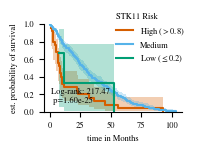

In [ ]:
fig, ax = plt.subplots(figsize=(1.9, 1.4))

for color, group_label in zip(
    [c_high_risk, c_medium_risk, c_low_risk],
        ("High", "Medium", "Low")):

    if len(risk_survival[risk_survival["group"] == group_label]) <= 1:
        continue

    patients = risk_survival[risk_survival["group"] == group_label]
    time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
        patients["Overall Survival Status"],
        patients["Overall Survival (Months)"],
        conf_type="log-log",
    )

    if group_label == "High":
        group_label += f" ($> {thresholds[1]}$)"
    elif group_label == "Low":
        group_label += f" ($\\leq {thresholds[0]}$)"

    ax.step(time_treatment, survival_prob_treatment,
            where="post", label=group_label, color=color)
    ax.fill_between(
        time_treatment, conf_int[0], conf_int[1],
        alpha=0.3, step="post", color=color, lw=0)

log_rank, p = compare_survival(
    risk_survival[["Overall Survival Status", "Overall Survival (Months)"]]
    .to_records(index=False),
    risk_survival["median_risk"],
)

ax.text(0.6, 0.1, f"Log-rank: {log_rank:.2f}\n p={p:.2e}")
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.set_ylim(0, 1)
ax.set_ylabel("est. probability of survival")
ax.set_xlabel("time in Months")
fig.tight_layout()
legend = ax.legend(loc=(0.5, 0.5), title=f"{event} Risk")
legend._legend_box.align = "left"
legend.set_frame_on(False)
fig.savefig(
    f"../results/figs/{data_name}_{event.lower()}" +
    f"_survival{('_immuno' if filter_immuno else '')}" +
    f"{('_kras' if filter_kras else '')}.pdf",
    dpi=300)

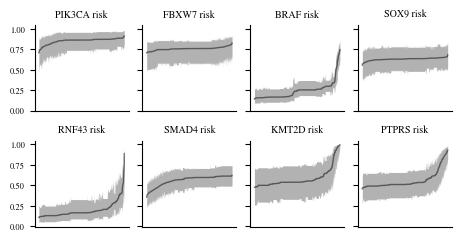

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(4.6, 2.4), sharey=True)

for i, event in enumerate([e for e in range(12) if e not in events]):

    a = ax[i // 4, i % 4]

    data_filtered = data.reset_index(drop=True)[
        data.reset_index(drop=True).iloc[:, event] == 0]
    sorting = None

    risk = risks[data_filtered.index, :, event]
    sorting = np.argsort(np.median(risk, axis=1))
    a.plot(np.median(risk, axis=1)[sorting], lw=1, alpha=0.5, color="black")
    a.fill_between(
        np.arange(risk.shape[0]),
        np.percentile(risk, 5, axis=1)[sorting],
        np.percentile(risk, 95, axis=1)[sorting],
        alpha=0.3, color="black", lw=0)
    a.set_title(f"{data.columns[event]} risk")
    for side in ["top", "right"]:
        a.spines[side].set_visible(False)
    a.set_xticks([])

fig.tight_layout()
fig.savefig(
    f"../results/figs/{data_name}_risks_supp.pdf",
)